In [1]:
import requests
import json
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools
from itertools import product
import seaborn as sns
from scipy.stats import bernoulli
from scipy.stats import multivariate_normal
from random import random
import copy

In [2]:
df = pd.read_csv('../data/spotify_dataset.csv', usecols=range(4), lineterminator='\n', header=0)

In [3]:
df.columns = [x.replace('"', '').lstrip() for x in df.columns]

In [4]:
playlists = df['playlistname'].unique()
print('Number of Playlists:', len(playlists))
print('Number of Artists:', len(df['artistname'].unique()))

Number of Playlists: 161530
Number of Artists: 290002


#### Problem:
- Networkx takes too much time to load up a graph with all the data <br>
- In ~5 min we can retrieve 2000 artist genres


#### Potential Solution:
- Sample 1,000 playlists
- See if there is a sufficient amount of artists and playlist appearances

In [5]:
np.random.seed(0)
sample_size = 500
sample_playlists = np.random.choice(playlists, sample_size, replace=False)
sampled_df = df[df['playlistname'].isin(sample_playlists)]

In [6]:
print('Number of songs in sample:', len(sampled_df))
print('Number of Artists:', len(sampled_df['artistname'].unique()))

Number of songs in sample: 33226
Number of Artists: 6723


In [7]:
appearances = sampled_df.groupby('artistname').agg({'trackname':'count', 'playlistname':lambda x: len(x.unique())})
appearances.sort_values(by=['trackname', 'playlistname'])

,trackname,playlistname
artistname,,
!!!,1,1
047,1,1
10 Years,1,1
10cc,1,1
112,1,1
...,...,...
David Grisman,289,1
Jethro Tull,323,4
Neil Young,371,4


- There are some artists that appear on an insignificant amount of playlists, define this to be anything less than 10

In [8]:
artists = appearances[appearances['playlistname']>=10].index
print('# of artists on >= 10 playlists (sample):', len(artists))

# of artists on >= 10 playlists (sample): 55


In [9]:
df1 = sampled_df[sampled_df['artistname'].isin(artists)]
df1.head(10)

,user_id,artistname,trackname,playlistname
85483,424678a7d04868568c9f95863a901d88,Katy Perry,Firework,heartlifting
85484,424678a7d04868568c9f95863a901d88,Daft Punk,Get Lucky - Radio Edit,heartlifting
110332,26916a44c7af854db436d562704b88a1,Queen,Somebody To Love (Live In Montreal),Don Diablo
156728,ea0e4bd5eb86a066c6ff6a275c253704,David Guetta,Bad (feat. Vassy) - Radio Edit,David Guetta — Listen (Deluxe)
156729,ea0e4bd5eb86a066c6ff6a275c253704,David Guetta,Bang my Head (feat. Sia),David Guetta — Listen (Deluxe)
156730,ea0e4bd5eb86a066c6ff6a275c253704,David Guetta,Dangerous (feat. Sam Martin),David Guetta — Listen (Deluxe)
156731,ea0e4bd5eb86a066c6ff6a275c253704,David Guetta,Dangerous (feat. Sam Martin) - Robin Schulz Re...,David Guetta — Listen (Deluxe)
156732,ea0e4bd5eb86a066c6ff6a275c253704,David Guetta,Goodbye Friend (feat. The Script),David Guetta — Listen (Deluxe)
156733,ea0e4bd5eb86a066c6ff6a275c253704,David Guetta,Hey Mama (feat. Nicki Minaj & Afrojack),David Guetta — Listen (Deluxe)
156734,ea0e4bd5eb86a066c6ff6a275c253704,David Guetta,I'll Keep Loving you (feat. Birdy & Jaymes Young),David Guetta — Listen (Deluxe)


- Only take playlists that have more than 1 artist (otherwise there's no edge)

In [10]:
df1_grped = df1.groupby('playlistname').agg({'artistname':lambda x: len(x.unique())})
playlists = df1_grped[df1_grped['artistname'] > 1].index

In [11]:
df2 = df1[df1['playlistname'].isin(playlists)]
df2.head(10)

,user_id,artistname,trackname,playlistname
85483,424678a7d04868568c9f95863a901d88,Katy Perry,Firework,heartlifting
85484,424678a7d04868568c9f95863a901d88,Daft Punk,Get Lucky - Radio Edit,heartlifting
110332,26916a44c7af854db436d562704b88a1,Queen,Somebody To Love (Live In Montreal),Don Diablo
200335,851f4dce324bc81546ccde8a360db07f,Arcade Fire,Keep the Car Running,run
233840,47aa0a0b2b0842243da613ee369d8c59,David Guetta,Blast off,Various Artists — Furious 7: Original Motion P...
233841,47aa0a0b2b0842243da613ee369d8c59,Flo Rida,GDFR (feat. Sage The Gemini and Lookas) - Nood...,Various Artists — Furious 7: Original Motion P...
233843,47aa0a0b2b0842243da613ee369d8c59,Wiz Khalifa,Go Hard or Go Home,Various Artists — Furious 7: Original Motion P...
233848,47aa0a0b2b0842243da613ee369d8c59,T.I.,Off-set,Various Artists — Furious 7: Original Motion P...
233851,47aa0a0b2b0842243da613ee369d8c59,Wiz Khalifa,See You Again (feat. Charlie Puth),Various Artists — Furious 7: Original Motion P...
354684,9153ee804f67f9a47513c310e8d57420,Avicii,Superlove,Bike


In [12]:
unq_play = sampled_df.groupby(['artistname', 'playlistname']).count().reset_index().groupby('artistname').count()[['playlistname']].reset_index()
# unq_play = unq_play.groupby('playlistname').count()
unq_play.head(10)


,artistname,playlistname
0,!!!,1
1,047,1
2,10 Ft. Ganja Plant,1
3,10 Years,1
4,10cc,1
5,112,1
6,12 Stones,1
7,1349,1
8,1910 Fruitgum Company,1
9,1999,1


[Text(0.5, 0, 'frequency'), Text(0.5, 1.0, 'Top 10 artist frequencies')]

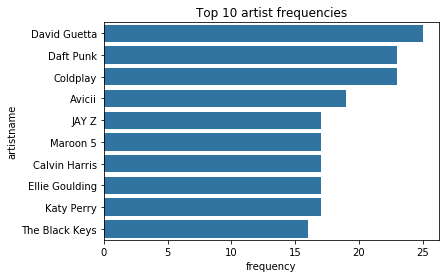

In [13]:
top_10 = unq_play.sort_values(by = 'playlistname', ascending = False)[:10]
f, ax = plt.subplots()
sns.set_color_codes("pastel")
sns.barplot(y="artistname", x="playlistname", data=top_10, orient = 'h', color = '#1f77b4')
ax.set(xlabel = 'frequency', title = 'Top 10 artist frequencies')

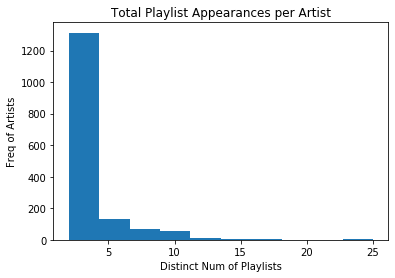

In [14]:
plt.hist(unq_play[(unq_play['playlistname'] > 1)]['playlistname'], bins=10)
plt.xlabel('Distinct Num of Playlists')
plt.ylabel('Freq of Artists')
plt.title('Total Playlist Appearances per Artist')
plt.savefig('playlistapp')

In [15]:
# same def as quarter 1
def read_edge(gph, n0, n1):
    if gph.has_edge(n0, n1):
        gph[n0][n1]['weight'] +=1
        return gph[n0][n1]['weight']
    else:
        gph.add_edge(n0, n1, weight=1)
        return 1

In [16]:
%%time
G = nx.Graph()
# if not unique, could weight the number of times the artist appears in that playlist
df2_grp = df2.groupby('playlistname').agg({'artistname': lambda x: (x).unique()})

for i in range(len(df2_grp)):
    
    for a in (df2_grp.iloc[i]):
        for a1, a2 in itertools.combinations(a, 2):
            read_edge(G, a1, a2)


CPU times: user 24.8 ms, sys: 1.76 ms, total: 26.6 ms
Wall time: 26.1 ms


In [17]:
# threshold = 1
# long_edges = list(filter(lambda e: e[2] <= threshold, (e for e in G.edges.data('weight'))))
# G.remove_edges_from(long_edges)

CPU times: user 155 ms, sys: 23.2 ms, total: 179 ms
Wall time: 79.5 ms


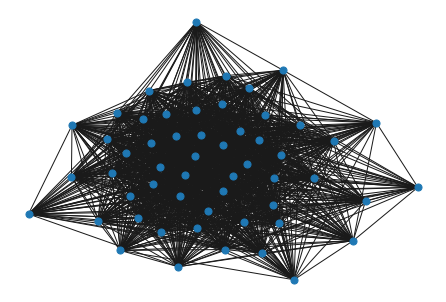

In [18]:
%%time
nx.draw(G, node_size=50)


In [19]:
# # [n for n in G.neighbors]
# neighbors = []
# for i in G.nodes:
#     count = 0
#     for k in G.neighbors(i):
#         count += 1
#     neighbors.append(count)
# neigh_df = pd.DataFrame(G.nodes)
# neigh_df['neighbors'] = neighbors
# neigh_df
# plt.hist(neigh_df['neighbors'])
# plt.xlabel('Number of Neighbors')
# plt.ylabel('Node Count')
# plt.title('Node Freq of Neighbor Count')
# plt.savefig('node_freq')

In [20]:
weight_dict = {}
node_weights = nx.get_edge_attributes(G, "weight")
for i in node_weights:
    if 'Justin Timberlake' in i:
        weight_dict[i] = node_weights[i]

In [21]:
sorted(weight_dict.items(), key=lambda x:x[1], reverse=True)[:10]

[(('Maroon 5', 'Justin Timberlake'), 7),
 (('Justin Timberlake', 'JAY Z'), 7),
 (('Justin Timberlake', 'Katy Perry'), 6),
 (('Beyoncé', 'Justin Timberlake'), 5),
 (('Pitbull', 'Justin Timberlake'), 5),
 (('Rihanna', 'Justin Timberlake'), 5),
 (('Justin Timberlake', 'The Black Keys'), 5),
 (('Justin Timberlake', 'Passenger'), 5),
 (('Justin Timberlake', 'Ed Sheeran'), 5),
 (('Justin Timberlake', 'Britney Spears'), 5)]

In [22]:
len(G.nodes)

55

In [23]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

def get_artist_genres(artist_names):
    client_id = '8ac5bd4f29854a4abb37648a5b7833d8'
    client_secret = 'c9f1281a0f774d97ae7d002139e53049'
    client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

    artist_dict = {}
    
    for artist in artist_names:
        result = sp.search(artist, type='artist')['artists']['items']
        if len(result) > 0:
            artist_dict[artist] = result[0]['genres']
    return artist_dict


In [24]:
genres = get_artist_genres(list(G.nodes))

In [25]:
# dare's algorithm work don't worry about it
# def L_g_grad(u, F, A):
#     sum1 = 0
#     sum2 = 0
#     for edge in range(len(A[u])):
#         if A[u][edge] > 0:
#             print(-F[u] * F[edge].T, -F[u].dot(F[edge].T))
#             sum1 += np.log(1-np.exp(-F[u].dot(F[edge].T)))
#         else:
#             sum2 += F[u] * F[edge].T
#     return sum1 - sum2

# def train(A, Att, C, iterations = 100):
#     # initialize an F
#     N = A.shape[0]
#     F = np.random.rand(N,C)
#     X = Att
#     # weight matrix is (# of attributes, # of groups)
#     W = np.zeros((Att.shape[1], C))
#     F_new = F#np.zeros((N,C))
#     alpha = 0.01
#     ll = .01
#     ll_new = 0
#     W_new = W
#     for n in range(iterations):
#         dist = 0
#         F_old = F_new
#         for u in range(N):
#             L_g = (L_g_grad(u, F_new, A))
#             print(L_g, )
#             L_g = gradient(F, A, u) # derivative of L_g w/ respect to F_u (does this need to be F_new???)
#             Q = np.divide(1, 1 + np.exp(-W_new.dot(F_new[u].T)))
#             print(F_new[u])
#             L_x = alpha*((X[u]-Q).dot(W)) # derivative of L_x w/ respect to F_u
#             print(F_new[u], (np.zeros(C) < F_new[u] + alpha*(L_g+L_x)) * (F_new[u] + alpha*(L_g+L_x)))
#             F_new[u] = (np.zeros(C) < F_new[u] + alpha*(L_g+L_x)) * 1 * (F_new[u] + alpha*(L_g+L_x))
#             print(L_g,L_x)
#             W_new += alpha*(np.array(X[u]-Q)*(F_new[u])) - np.sign(W_new)


#         F_new += alpha*(X-Q).dot(W)
#         F = np.maximum(.01, F_new) # should this be 0?
#         ll_new = log_likelihood(F, A)
#         ll_new += np.sum(X*np.log(np.maximum(.01, Q)) + (1 - X)*np.log(np.maximum(.01, 1 - Q)))
#         change = (ll - ll_new) / ll
#         print(alpha*(np.dot((X-Q).T, F)) - np.sign(W_new))
#         if abs(change) < .001:
#             break
#         else:
#             ll = ll_new
#     print(n, W_new - np.sign(W_new))
#     delta = (-np.log(1- (1/N)))**.5
#     return F>delta, W_new

,user_id,artistname,trackname,playlistname


In [26]:
# implement algorithm
def standardize_matrix(A):
    max_edge = 0
    for i in nx.to_numpy_array(G):
        if (max(i)) > max_edge:
            max_edge = max(i)
    stand_A = []
    for row in nx.to_numpy_array(G):
        stand_row = []
        for edge in row:
            stand_row.append(edge/max_edge)
        stand_A.append(stand_row)
    return np.array(stand_A)


In [27]:
## algorithm work

# bigclam algorithm taken from https://github.com/RobRomijnders/bigclam
def sigm(x):
    return np.divide(np.exp(-1.*x),1.-np.exp(-1.*x))

def log_likelihood(F, A):
    """implements equation 2 of 
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf"""
    A_soft = F.dot(F.T)

    # Next two lines are multiplied with the adjacency matrix, A
    # A is a {0,1} matrix, so we zero out all elements not contributing to the sum
    FIRST_PART = A*np.log(1.-np.exp(-1.*A_soft))
    sum_edges = np.sum(FIRST_PART)
    SECOND_PART = (1-A)*A_soft
    sum_nedges = np.sum(SECOND_PART)

    log_likeli = sum_edges - sum_nedges
    return -log_likeli

def gradient(F, A, i):
    """Implements equation 3 of
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf
    
      * i indicates the row under consideration
    
    The many forloops in this function can be optimized, but for
    educational purposes we write them out clearly
    """
    N, C = F.shape

    neighbours = np.where(A[i])
    nneighbours = np.where(1-A[i])

    sum_neigh = np.zeros((C,))
    for nb in neighbours[0]:
        dotproduct = F[nb].dot(F[i])
        sum_neigh += F[nb]*sigm(dotproduct)

    sum_nneigh = np.zeros((C,))
    #Speed up this computation using eq.4
    for nnb in nneighbours[0]:
        sum_nneigh += F[nnb]

    grad = sum_neigh - sum_nneigh
    return grad

def train(A, Att, C, iterations = 100, alpha = .005, lambda_W = .001):
    # initialize an F
    N = A.shape[0]
    F = np.random.rand(N,C)
    F_new = np.zeros((N,C))
    X = Att
    W = np.random.rand(Att.shape[1], C)
    W_new = np.zeros((Att.shape[1], C))
    ll = .01
    ll_new = 0
    Q = np.zeros((F.shape[0], W.shape[0]))
    Sanity = np.zeros((F.shape[0], W.shape[0]))
    for n in range(iterations):
        for u in range(Q.shape[0]):
            for k in range(Q.shape[1]):
                running_sum = 0
                for c in range(F.shape[1]):
                    running_sum += W[k][c] * F[u][c]
                Q[u][k] = 1/(1+np.exp(-running_sum))
        
        for u in range(X.shape[0]):
            grad = gradient(F, A, u)
            for c in range(F.shape[1]):
                running_sum = 0
                for k in range(X.shape[1]):
                    running_sum += (X[u][k] - Q[u][k]) * W[k][c]
                F_new[u][c] = max(.001, F[u][c] + alpha*(running_sum + grad[c]))
        
        for k in range(X.shape[1]):
            for c in range(F.shape[1]):
                running_sum = 0
                for u in range(F.shape[0]):
                    running_sum += (X[u][k] - Q[u][k]) * F[u][c]
                W_new[k][c] = W[k][c] + alpha * running_sum - alpha * lambda_W * np.sign(W[k][c])

        F = copy.deepcopy(F_new)
        W = copy.deepcopy(W_new)
        ll_new = log_likelihood(F, A)
        ll_new += np.sum(np.maximum(.001, X*np.log(np.maximum(.001, Q)) + (1 - X)*np.log(np.maximum(.001, 1 - Q))))
        change = (ll - ll_new) / ll
        if abs(change) < .001:
            break
        else:
            ll = ll_new
    delta = (-np.log(1 - (1/N)))**.5
    
    return F, delta, W

In [40]:
# define attributes and group size
att = df2.groupby('artistname').agg({'playlistname':lambda x: len(np.unique(np.array(list(x)))) >= 10}) * 1
att = np.array([pd.Series([node for node in G.nodes]).apply(lambda x: dict(zip(att.index, att.playlistname))[x])]).T

c = 3 # group size


In [43]:
# try w/ binary adjacency
nodes = [node for node in G]
A = (nx.to_numpy_array(G) >= 1) * 1
iterations = 10
F, delta, W = train(A, att, c, iterations)
print('sample size is: ' + str(sample_size), ', group size: ' + str(c), ', iterations: ' + str(iterations))
print(np.argmax(F, 1))
print(W)

sample size is: 500 , group size: 3 , iterations: 10
[1 2 1 0 1 2 2 1 1 2 1 1 2 2 1 1 1 1 0 1 1 0 2 1 2 0 0 1 0 0 2 2 2 2 1 2 0
 2 2 2 1 2 1 1 2 2 1 1 1 0 2 0 0 1 1]
[[0.82154614 1.00098323 0.09420574]]


In [45]:
# try stardardized adjacency
nodes = [node for node in G]
A = nx.to_numpy_array(G)
A = standardize_matrix(A)
iterations = 10
F, delta, W = train(A, att, c)
print('sample size is: ' + str(sample_size), ', group size: ' + str(c), ', iterations: ' + str(iterations))
print(np.argmax(F, 1))
print(W)

sample size is: 500 , group size: 3 , iterations: 10
[0 1 0 0 0 0 0 1 0 1 0 0 2 1 0 2 0 1 0 1 0 2 1 0 1 2 2 0 0 2 0 0 1 1 0 0 2
 0 0 1 0 1 1 1 1 2 0 0 1 1 1 0 0 1 0]
[[0.70596533 0.76416399 0.68919815]]


In [47]:
nodes_pred = dict(zip(nodes, np.argmax(F,1)))


In [48]:
# calc percent of top edges are in the same group
dict_nodes_edg_grp = {}
node_weights = nx.get_edge_attributes(G, "weight")
for i in nodes:
    dict_nodes_edg_grp[i] = []
    weight_dict = {}
    for j in node_weights:
        if i in j:
            weight_dict[j] = (node_weights[j], [nodes_pred[j[0]], nodes_pred[j[0]]])
    weight_dict = sorted(weight_dict.items(), key=lambda x:x[1], reverse=True)
    dict_nodes_edg_grp[i].append(weight_dict[:3])
    

In [49]:
sorted(nodes_pred.items(), key=lambda x:x[1], reverse=True)

[('Oasis', 2),
 ('David Guetta', 2),
 ('Drake', 2),
 ('Lana Del Rey', 2),
 ('Arcade Fire', 2),
 ('Mumford & Sons', 2),
 ('La Roux', 2),
 ('Stevie Wonder', 2),
 ('Beyoncé', 1),
 ('Fleetwood Mac', 1),
 ('Queen', 1),
 ('Elvis Presley', 1),
 ('Avicii', 1),
 ('Katy Perry', 1),
 ('JAY Z', 1),
 ('Tiësto', 1),
 ('Britney Spears', 1),
 ('Kanye West', 1),
 ('Madonna', 1),
 ('Skrillex', 1),
 ('T.I.', 1),
 ('2Pac', 1),
 ('Linkin Park', 1),
 ('Wiz Khalifa', 1),
 ('Flo Rida', 1),
 ('deadmau5', 1),
 ('Lil Wayne', 1),
 ('Maroon 5', 0),
 ('Pitbull', 0),
 ('Shakira', 0),
 ('Rihanna', 0),
 ('Justin Timberlake', 0),
 ('The Black Keys', 0),
 ('Ellie Goulding', 0),
 ('Daft Punk', 0),
 ('The Killers', 0),
 ('The Smiths', 0),
 ('Coldplay', 0),
 ('OneRepublic', 0),
 ('Imagine Dragons', 0),
 ('Ed Sheeran', 0),
 ('Calvin Harris', 0),
 ('Jason Derulo', 0),
 ('Eminem', 0),
 ('Passenger', 0),
 ('The Cure', 0),
 ('Passion Pit', 0),
 ('Prince', 0),
 ('Phil Collins', 0),
 ('The xx', 0),
 ('Lady Gaga', 0),
 ('Snoop Dog

In [ ]:
weight_dict = {}
node_weights = nx.get_edge_attributes(G, "weight")
for i in node_weights:
    if 'Phoenix' in i:
        weight_dict[i] = (node_weights[i], [nodes_pred[i[0]], nodes_pred[i[1]]])
        

In [ ]:
sorted(weight_dict.items(), key=lambda x:x[1], reverse=True)

In [ ]:
[x for x in nodes_pred if nodes_pred[x]==2]

In [ ]:
# Node attributes

In [ ]:
df2
# avg songs per playlist
x = df2.groupby('artistname').agg({'playlistname':lambda x: len(np.unique(np.array(list(x)))), 'trackname':'count'})
x['trackname'] / x['playlistname']


In [ ]:
# total songs
x = df2.groupby('artistname').agg({'trackname':'count'})
x


In [ ]:
# song variety - closer to 1: unique song on every playlist, closer to 0: many songs in common over playlists
x = df2.groupby('artistname').agg({'trackname':lambda x: len(np.unique(np.array(list(x)))), 'playlistname':'count'})
(x['trackname'] / x['playlistname']).sort_values()


In [ ]:
# playlist appearances
x = df2.groupby('artistname').agg({'playlistname':lambda x: len(np.unique(np.array(list(x))))})
x.sort_values(by='playlistname')
x['playlistname'].groupby(x['playlistname']).count()


In [ ]:
x.mean()
